In [24]:
%reload_ext autoreload

%autoreload 2

In [25]:
from Libraries_functions import *
from tqdm import tqdm
import glob
import ipywidgets as widgets
from IPython.display import display

In [26]:
preprocess_files()

 12%|█▏        | 24/200 [00:00<00:01, 111.63it/s]

Processed file ../../Datasets/Test/mixed_sound/mixed_sound10066.wav


100%|██████████| 200/200 [00:01<00:00, 119.21it/s]


## Cargamos el modelo y los datos

In [27]:
# model= VAE.load(PATH_TO_MODEL)

min_max_values= load_min_max(MIN_MAX_VALUES)
spectrograms, file_path = load_form_direc(SPECTROGRAMS_SAVE_DIR)
sampled_specs, sampled_min_max_values, file_path = select_spectrograms(spectrograms, file_path, min_max_values, num_spectrograms=20)
voice_paths= search_voices(file_path)

['../../Datasets/Data/tests/mixed_sound6426.wav.npy', '../../Datasets/Data/tests/mixed_sound9311.wav.npy', '../../Datasets/Data/tests/mixed_sound4943.wav.npy', '../../Datasets/Data/tests/mixed_sound1635.wav.npy', '../../Datasets/Data/tests/mixed_sound13063.wav.npy', '../../Datasets/Data/tests/mixed_sound28346.wav.npy', '../../Datasets/Data/tests/mixed_sound28589.wav.npy', '../../Datasets/Data/tests/mixed_sound18846.wav.npy', '../../Datasets/Data/tests/mixed_sound15336.wav.npy', '../../Datasets/Data/tests/mixed_sound24559.wav.npy', '../../Datasets/Data/tests/mixed_sound35620.wav.npy', '../../Datasets/Data/tests/mixed_sound44539.wav.npy', '../../Datasets/Data/tests/mixed_sound44716.wav.npy', '../../Datasets/Data/tests/mixed_sound36565.wav.npy', '../../Datasets/Data/tests/mixed_sound43719.wav.npy', '../../Datasets/Data/tests/mixed_sound55806.wav.npy', '../../Datasets/Data/tests/mixed_sound54755.wav.npy', '../../Datasets/Data/tests/mixed_sound49799.wav.npy', '../../Datasets/Data/tests/mixe

## load from vae_auto_propio

In [28]:
model_name="VAE_weights_build_VAE_Skipp_complejo_loss_0.0_alpha_0.3_dim_2048"
alpha=0.3
latent=2048
learning_rate=0.0001

vae, _=VAE.load_model_complete(sampled_specs,alpha,latent, learning_rate)
# vae=VAE.load_model(sampled_specs,alpha,latent, learning_rate)

vae= VAE.load_model_weights(vae, save_folder= PATH_TO_MODEL, name=f"{model_name}.h5")

signals=vae.predict(sampled_specs)

Model: "decoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_23 (Conv2D)             (None, 256, 256, 32  320         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_24 (Conv2D)             (None, 256, 256, 32  9248        ['conv2d_23[0][0]']              
                                )                                                           

c:\Users\javca\anaconda3\envs\Ceiec\lib\site-packages\keras\engine\training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


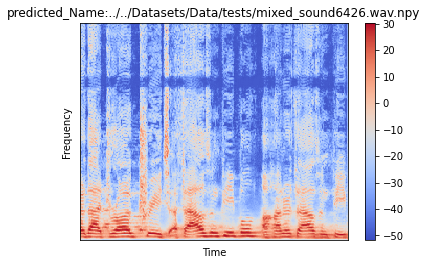

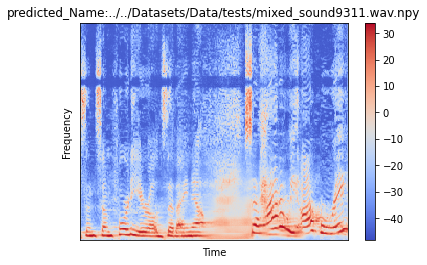

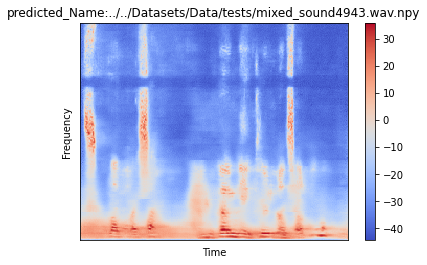

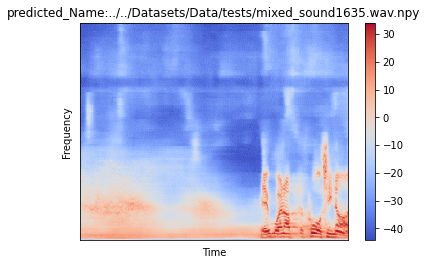

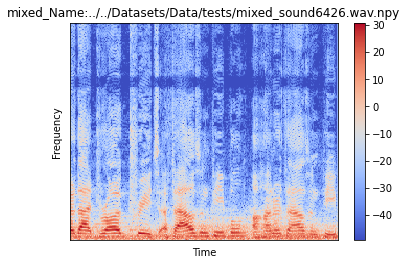

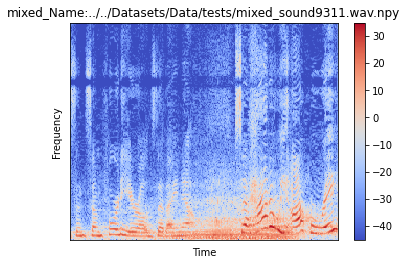

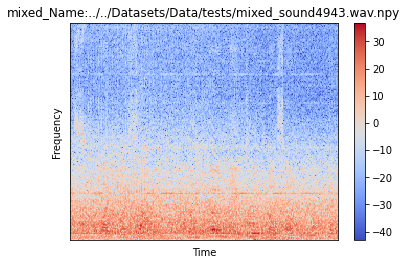

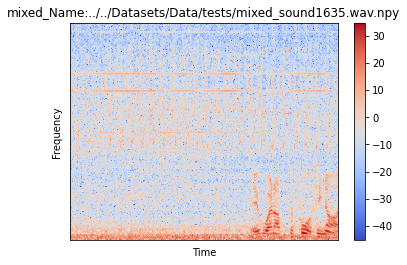

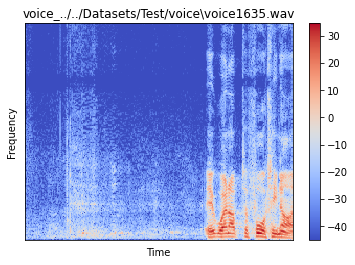

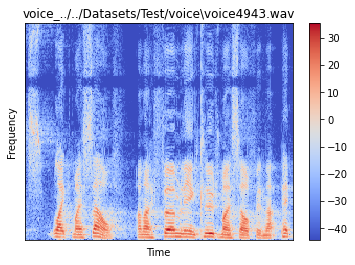

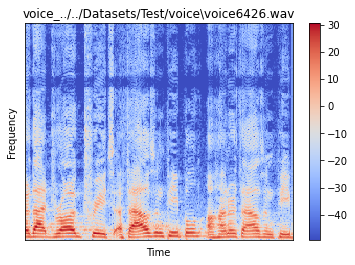

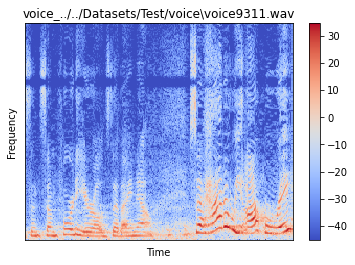

In [29]:
new_signals, predicted_path = convert_spectrograms_to_audio(
    signals, sampled_min_max_values,False,file_path )

original_signals, mixed_path = convert_spectrograms_to_audio(
    sampled_specs, sampled_min_max_values,True, file_path)

real_signals, real_path=spectrograms_of_voice(voice_paths)

In [30]:
style = {'description_width': 'initial'}

generating= widgets.Dropdown(
    options=[('Metrics', 0), ('Generate audios', 1)],
    value=1,
    description='Select_metrics or Generate audios',
    style=style,
    layout={'width': 'max-content'}
)

display(generating)

Dropdown(description='Select_metrics or Generate audios', index=1, layout=Layout(width='max-content'), options…

In [31]:
if generating.value==1:
    for i in range(len(predicted_path)):
        predicted_path[i]=predicted_path[i].split("d")[-1].split(".")[0]
    for i in range(len(mixed_path)):
        mixed_path[i]=mixed_path[i].split("d")[-1].split(".")[0]
    for i in range(len(real_path)):
        real_path[i]=real_path[i].split("e")[-1].split(".")[0]
    save_signals(new_signals, SAVE_DIR_GENERATED, predicted_path, "predicted_")
    save_signals(original_signals, SAVE_DIR_ORIGINAL, mixed_path, "mixed_")
    save_signals(real_signals, SAVE_DIR_REAL, real_path, "real_")
else:
########################################################################################################################
# MSE Metrics
    aircrafts=[]
    lluvia=[]
    trafico=[]
    viento=[]
    for i in tqdm(range(df_data.shape[0])):
        if(i<df_data.shape[0]/4-1):
            aircrafts.append(mean_squared_error(df_data.data[i], df_data.noise_original[i],squared=True))
        elif(i>=df_data.shape[0]/4-1 and i<df_data.shape[0]/4+499-1):
            lluvia.append(mean_squared_error(df_data.data[i], df_data.noise_original[i],squared=True))
        elif(i>=df_data.shape[0]/4+499-1 and i<df_data.shape[0]/4+499*2-1):
            trafico.append(mean_squared_error(df_data.data[i], df_data.noise_original[i],squared=True))
        else:
            viento.append(mean_squared_error(df_data.data[i], df_data.noise_original[i],squared=True))

    
    df_MSE=pd.DataFrame()
    df_MSE.insert(0,"aircrafts_mean",[mean(aircrafts)])
    df_MSE.insert(1,"aircrafts_desviacion",[desviacion(aircrafts)])

    df_MSE.insert(2,"lluvia_mean",[mean(lluvia)])
    df_MSE.insert(3,"lluvia_desviacion",[desviacion(lluvia)])

    df_MSE.insert(4,"trafico_mean",[mean(trafico)])
    df_MSE.insert(5,"trafico_desviacion",[desviacion(trafico)])

    df_MSE.insert(6,"viento_mean",[mean(viento)])
    df_MSE.insert(7,"viento_desviacion",[desviacion(viento)])

    